In [1]:
'''
Load and plot chipod, adcp, and thermistor data from moorings. Use modules in modview only.
- - - As of september 22 2021, this is using an outdated version of modview.loader
- - - - - - most recent development is only stored locally in kuxan-suum.
- - - Mooring IDs will be used as example to define the main properties and relations of 
- - - - - - modview-compatible databases of datasets. 
'''

import numpy as np; import xarray as xr; import pandas as pd;
import matplotlib.pyplot as plt; import matplotlib as mpl;
import sys; import scipy.io as sio; import itertools;
import warnings; import datetime

# Figure out how to import local package on Juno (iPad). 
# For PC or Linux:
modview_path = '/media/mydrive/PhysOc/modview/modview';
sys.path.append(modview_path)
import loader
import viztools
import timetools

SyntaxError: invalid syntax (timetools.py, line 8)

In [ ]:
import importlib 
importlib.reload(loader);
importlib.reload(viztools)

Vamos a crear dos objetos (instancias de loader.assemble) para almacenar informacion de dos boyas oceanograficas. Empezamos definiendo los parametros de cada instancia.

In [3]:
# Begin by creating an instance of the assemble class. 
sio1_limits = {'t0':'2018 Sep 15','t1':'2019 Oct 31'};
sio1_data_dir = '/media/mydrive/PISTON/Moorings/SIO1/'; 
#sio1_data_dir = '/mnt/sda1/SciData/PISTON/Moorings/SIO1/';
sio1_adcp_paths = ['SIO1_4021.nc','SIO1_11181.nc','SIO1_3160.nc'];
sio1_paths = {'chipod':sio1_data_dir+'SIO1_chipod.mat','chiflags':sio1_data_dir+'SIO1_chipod_finflag.csv',
             'ADCP':[sio1_data_dir + 'ADCP/' + kk for kk in sio1_adcp_paths],
             'Temperature':sio1_data_dir + 'SIO1_gridT_lores.mat'};
sio1_id = {'name':'SIO1','project':'PISTON','type':'Mooring','limits':sio1_limits};

sio3_limits = {'t0':'2018 Sep 15','t1':'2019 Oct 31'};
sio3_data_dir = '/media/mydrive/PISTON/Moorings/SIO3/'; 
#sio1_data_dir = '/mnt/sda1/SciData/PISTON/Moorings/SIO1/';
sio3_adcp_paths = ['SIO3_13596.nc','SIO3_14435.nc','SIO3_22525.nc'];
sio3_paths = {'chipod':sio3_data_dir+'SIO3_chipod.mat','chiflags':sio3_data_dir+'SIO3_chipod_finflag.csv',
             'ADCP':[sio3_data_dir + 'ADCP/' + kk for kk in sio3_adcp_paths],
             'Temperature':sio1_data_dir + 'SIO3_gridT_lores.mat'};
sio3_id = {'name':'SIO3','project':'PISTON','type':'Mooring','limits':sio1_limits};

Usamos esa informacion para crear las instancias de clase. 

In [4]:
SIO1 = loader.assemble(sio1_id,sio1_paths)
SIO3 = loader.assemble(sio3_id,sio3_paths)

Usa propiedades de las instancias para cargar los datos de cada boya.

In [80]:
SIO1.store_nc(SIO1.paths['ADCP'],['u','v','pressure'],limits=sio1_limits);
SIO3.store_nc(SIO3.paths['ADCP'],['u','v','pressure'],limits=sio3_limits)
SIO1.interp_grid(['u','v'],'z')
SIO3.interp_grid(['u','v'],'z')

Prepara lo necesario para generar una grid de los datos de chipod

In [135]:
importlib.reload(loader)
# With the instance created, now use mat tools in loader to load chipod data
# replace with loadmat from updated version of loader
chi_file = loader.matfile(SIO3.paths['chipod']);
chi_vars2get = ['time','eps','Kt','Jq','SN','znom']
chi_data = chi_file.read_struct('SIO3_chipod',chi_vars2get);

# Get processing flags 
chi_flags = pd.read_csv(SIO3.paths['chiflags']); 
# Then it's all about extracting cells from the matfile
SIO3.vars['chipod'] = dict(); 
for item in ['znom','SN']:
    SIO3.vars['chipod'][item] = chi_data[item]
for item in ['eps','Kt','Jq']: # vars to be interpolated
    SIO3.vars['chipod'][item] = loader.clean_chivar( \
                        chi_data, chi_flags,item, as_xr=True);

del chi_data, chi_file
''' All data is now stored indexed by serial number and time. 
Make xr objects that facilitate plotting and accounting for knockdown'''

SIO3.vars['knockdown'] = SIO3.grids['pressure'][0] - np.nanmin(SIO3.grids['pressure'][0]);
# interpolate knockdown to chipod time
raw_chi_time = pd.to_datetime(SIO3.vars['chipod']['eps'].time.values) 
chi_offset = SIO3.vars['knockdown'].interp( time=raw_chi_time, 
                                           method='nearest')
# knockdown + nominal depth
zchi = np.expand_dims(SIO3.vars['chipod']['znom'][0],axis=1) \
            + chi_offset.values;
SIO3.vars['chipod']['z'] = xr.DataArray( data=zchi.transpose(), \
                    dims=['time','SN'])

SIO3.vars['chipod'] = xr.Dataset(data_vars={\
         'eps':(['time','z'],SIO3.vars['chipod']['eps']),
        'Kt':(['time','z'],SIO3.vars['chipod']['Kt']),
        'Jq':(['time','z'],SIO3.vars['chipod']['Jq'])},
        coords={'time':raw_chi_time, 'z':SIO3.vars['chipod']['znom'][0],
               'depth':(['time','z'],zchi.transpose())}); 

Chipod variables are now stored in xr.DataArrays, indexed by serial number and time. Before gridding, create an xr.DataArray that helps account for mooring knockdown. 

In [106]:
chi_file = loader.matfile(SIO1.paths['chipod']);
chi_vars2get = ['time','eps','Kt','Jq','SN','znom']
chi_data = chi_file.read_struct('SIO1_chipod',chi_vars2get);

# Get processing flags 
chi_flags = pd.read_csv(SIO1.paths['chiflags']); 
# Then it's all about extracting cells from the matfile
SIO1.vars['chipod'] = dict(); 
for item in ['znom','SN']:
    SIO1.vars['chipod'][item] = chi_data[item]
for item in ['eps','Kt','Jq']: # vars to be interpolated
    SIO1.vars['chipod'][item] = loader.clean_chivar( \
                        chi_data, chi_flags,item, as_xr=True);
del chi_data, chi_file
''' All data is now stored indexed by serial number and time. 
Make xr objects that facilitate plotting and accounting for knockdown'''

SIO1.vars['knockdown'] = SIO1.grids['pressure'][0] \
                             - np.nanmin(SIO1.grids['pressure'][0]);
# interpolate knockdown to chipod time
raw_chi_time = pd.to_datetime(SIO1.vars['chipod']['eps'].time.values) 
chi_offset = SIO1.vars['knockdown'].interp( time=raw_chi_time, 
                                           method='nearest')
# knockdown + nominal depth
zchi = np.expand_dims(SIO1.vars['chipod']['znom'][0],axis=1) \
            + chi_offset.values;
SIO1.vars['chipod']['zmat'] = xr.DataArray( data=zchi.transpose(), \
                    dims=['time','SN'])

SIO1.vars['chipod'] = xr.Dataset(data_vars={\
         'eps':(['time','z'],SIO1.vars['chipod']['eps']),
        'Kt':(['time','z'],SIO1.vars['chipod']['Kt']),
        'Jq':(['time','z'],SIO1.vars['chipod']['Jq'])},
        coords={'time':raw_chi_time, 'z':SIO1.vars['chipod']['znom'][0],
               'depth':(['time','z'],zchi.transpose())}); 

In [101]:
SIO1.vars['chipod']['znom']

<xarray.DataArray 'znom' (znom: 14)>
array([232, 282, 340, 440, 540,  80,  85,  95, 105, 115, 130, 145, 167, 192],
      dtype=uint16)
Coordinates:
  * znom     (znom) uint16 232 282 340 440 540 80 85 95 105 115 130 145 167 192

In [210]:
def plot_period(obs, dsource,variable, axes, limits,resamp='none', log=False, contour=False,**kwargs):
    # obs is an instance of loader.assemble
    # variables is dict() to access variable to plot
    # axes is where the plot will be made. 
    # limits is the typical dict with t0,t1,z0,z1
    
    if dsource == 'ADCP': # get xr.DataArray
        var_dat = obs.vars[variable];
        var_dat = var_dat.sel(z=slice(limits['z0'],limits['z1']));
        z_here = var_dat['z'].values;
    elif dsource == 'chipod':
        var_dat = obs.vars['chipod'][variable]
        #var_dat = var_dat.sel(z=slice(limits['z0'],limits['z1']));
        #z_here = obs.vars['chipod']['znom'].values;
    var_dat = var_dat.sel(time=slice(limits['t0'],limits['t1'])); # apply limits
    
    if resamp == 'none':
        pass
    else:
        var_dat = var_dat.resample(time=resamp).mean(); 
    if log:
        var_vals = np.log10(var_dat.values);
    else: 
        var_vals = var_dat.values;
    if dsource=='chipod':
        var_vals = var_vals.transpose();
        
    # Prepare visualization format 
    viz_args = {'cmap':'viridis','vmin':-1,'vmax':1,'shading':'flat','levels':'none'};
    for arg in viz_args.keys():
        if arg in kwargs:
            viz_args[arg] = kwargs.get(arg);
            
    tvec = pd.to_datetime(var_dat.time.values)
    if contour:
        del viz_args['vmin'], viz_args['vmax']
        panel=axes.contourf(tvec, var_dat.z,var_vals, **viz_args)
    else:
        del viz_args['levels']
        panel = axes.pcolormesh(tvec, var_dat.z, var_vals, **viz_args)
    return panel

In [211]:
def update_v(obs):
    obs.vars['u'] = obs.vars['u'].interpolate_na(dim='z',limit=2)
    obs.vars['v'] = obs.vars['v'].interpolate_na(dim='z',limit=2)
def get_shear2(obs):
    uz = obs.vars['u'].differentiate(coord='z')
    vz = obs.vars['v'].differentiate(coord='z')
    s2 = uz.values**2 + vz.values**2;
    s2 = xr.DataArray(data=uz,coords=obs.vars['u'].coords)
    return s2

In [212]:
SIO3.vars['u'] = SIO3.vars['u'].interpolate_na(dim='z',limit=2)
SIO3.vars['s2'] = get_shear2(SIO3)

<ipython-input-210-6f70e64470e9>:40: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  panel = axes.pcolormesh(tvec, var_dat.z, var_vals, **viz_args)
<ipython-input-210-6f70e64470e9>:40: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  panel = axes.pcolormesh(tvec, var_dat.z, var_vals, **viz_args)
<ipython-input-210-6f70e64470e9>:37: UserWarning: The following kwargs were not used by contour: 'shading'
  panel=axes.contourf(tvec, var_dat.z,var_vals, **viz_args)
<ip

(400.0, 0.0)

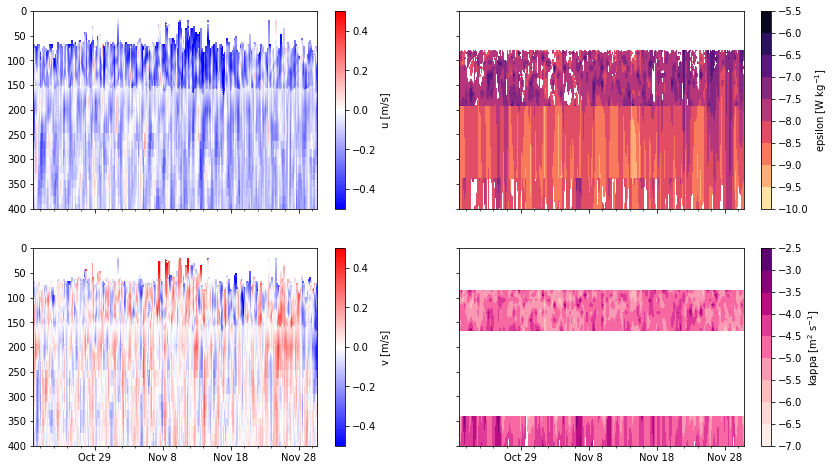

In [252]:
# Plot properties
importlib.reload(viztools)
plot_lims = {'t0':'2018-10-20','t1':'2018-11-30','z0':0,'z1':500}
u_format = {'cmap':'bwr','vmin':-0.5, 'vmax':0.5};
s2_format = {'cmap':'PiYG','vmin':-.01, 'vmax':.01}
eps_format = {'cmap':'magma_r','vmin':-10, 'vmax':-6,'shading':'auto','levels':np.arange(-10,-5,0.5)}
k_format = {'cmap':'RdPu','levels':np.arange(-7,-2,0.5)}


# Start plotting
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=[14,8]);
uplot = plot_period(SIO1, 'ADCP','u',ax[0,0],plot_lims,resamp='3H',log=False, **u_format)
s2plot = plot_period(SIO1,'ADCP','v',ax[1,0],plot_lims,resamp='3H',log=False,**u_format)
epsplot = plot_period(SIO1, 'chipod','eps',ax[0,1],plot_lims,resamp='6H',log=True, contour=True, **eps_format)
kplot = plot_period(SIO1, 'chipod','Kt',ax[1,1],plot_lims,resamp='6H',log=True, contour=True, **k_format)

for kk in [0,1]:
    for jj in [0,1]:
        viztools.dateticks2(ax[jj,kk], [2,10])

plt.colorbar(uplot,ax=ax[0,0],label='u [m/s]')
plt.colorbar(s2plot,ax=ax[1,0], label='v [m/s]')
plt.colorbar(epsplot,ax=ax[0,1], label='epsilon [W kg$^{-1}$]')
plt.colorbar(kplot, ax=ax[1,1], label='kappa [m$^2$ s$^{-1}$]')
ax[0,0].set_ylim((400,0))

In [237]:
# Extract near inertial signal
nearf = timetools.nearf(12.3);
SIO1.vars['NI_u'] = timetools.xpass( SIO1.vars['u'].fillna(0), nearf,
                1/3600, 'bandpass') + 1j*timetools.xpass(\
                SIO1.vars['v'].fillna(0),nearf, 1/3600, 'bandpass'); 
SIO1.vars['NI_u'][np.isnan(SIO1.vars['u'].values)] = np.nan;
SIO1.vars['NI_u'] = xr.DataArray( np.abs(SIO1.vars['NI_u']), coords=SIO1.vars['u'].coords);

SIO3.vars['NI_u'] = timetools.xpass( SIO3.vars['u'].fillna(0), nearf,
                1/3600, 'bandpass') + 1j*timetools.xpass(\
                SIO3.vars['v'].fillna(0),nearf, 1/3600, 'bandpass'); 
SIO3.vars['NI_u'][np.isnan(SIO3.vars['u'].values)] = np.nan;
SIO3.vars['NI_u'] = xr.DataArray( np.abs(SIO3.vars['NI_u']), coords=SIO3.vars['u'].coords);

In [238]:
SIO1.vars['NI_u']

<xarray.DataArray (z: 334, time: 9192)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time     (time) datetime64[ns] 2018-09-19T00:30:00 ... 2019-10-06T23:30:0...
  * z        (z) float64 8.0 8.0 12.0 12.0 ... 1.568e+03 1.584e+03 1.584e+03

<ipython-input-210-6f70e64470e9>:37: UserWarning: The following kwargs were not used by contour: 'shading'
  panel=axes.contourf(tvec, var_dat.z,var_vals, **viz_args)
<ipython-input-210-6f70e64470e9>:40: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  panel = axes.pcolormesh(tvec, var_dat.z, var_vals, **viz_args)
<ipython-input-210-6f70e64470e9>:37: UserWarning: The following kwargs were not used by contour: 'shading'
  panel=axes.contourf(tvec, var_dat.z,var_vals, **viz_args)
<ipython-input-210-6f70e64470e9>:37: UserWarning: The following kwargs were not used by contour: 'shading'
  panel=axes.contourf(tvec, var_dat.z,var_vals, **viz_args)


(600.0, 15.0)

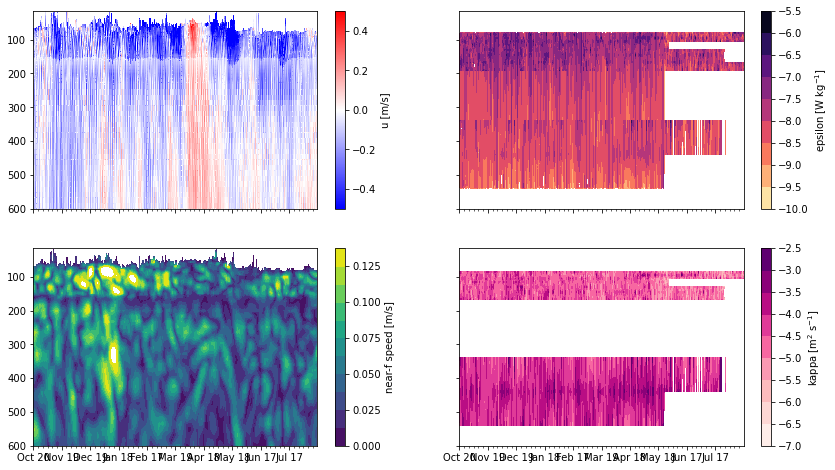

In [260]:
# Plot properties
importlib.reload(viztools)
plot_lims = {'t0':'2018-10-20','t1':'2019-08-15','z0':0,'z1':700}
NI_format = {'cmap':'viridis','levels':np.arange(0,0.15,0.0125)};
u_format = {'cmap':'bwr','vmin':-0.5, 'vmax':0.5};
s2_format = {'cmap':'PiYG','vmin':-.01, 'vmax':.01}
eps_format = {'cmap':'magma_r','vmin':-10, 'vmax':-6,'shading':'auto','levels':np.arange(-10,-5,0.5)}
k_format = {'cmap':'RdPu','levels':np.arange(-7,-2,0.5)}


# Start plotting
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=[14,8]);
NIplot = plot_period(SIO1, 'ADCP','NI_u',ax[1,0],plot_lims,resamp='12H',log=False, contour=True, **NI_format)
uplot = plot_period(SIO1,'ADCP','u',ax[0,0],plot_lims,resamp='3H',log=False,**u_format)
epsplot = plot_period(SIO1, 'chipod','eps',ax[0,1],plot_lims,resamp='6H',log=True, contour=True, **eps_format)
kplot = plot_period(SIO1, 'chipod','Kt',ax[1,1],plot_lims,resamp='6H',log=True, contour=True, **k_format)

for kk in [0,1]:
    for jj in [0,1]:
        viztools.dateticks2(ax[jj,kk], [5,30])

plt.colorbar(NIplot,ax=ax[1,0],label='near-f speed [m/s]')
plt.colorbar(uplot,ax=ax[0,0], label='u [m/s]')
plt.colorbar(epsplot,ax=ax[0,1], label='epsilon [W kg$^{-1}$]')
plt.colorbar(kplot, ax=ax[1,1], label='kappa [m$^2$ s$^{-1}$]')
ax[0,0].set_ylim((600,15))

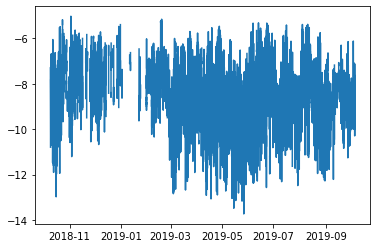

In [74]:
eps_526 = SIO3.vars['chipod']['eps'].loc[:,1];
plt.plot(np.log10(eps_526))

In [34]:
# Cut data in time for computing cost
tlims = {'t0':'2019-02-15','t1':'2019-06-01'};
u2plot = SIO3.vars['u'].sel(time=slice(tlims['t0'],tlims['t1']));
v2plot = SIO3.vars['v'].sel(time=slice(tlims['t0'],tlims['t1']));

fig, axes = plt.subplots(nrows=3, figsize=[7,8], sharex=True, 
                        sharey=True)
panel_u = axes[0].pcolormesh(u2plot.time, u2plot.z, u2plot, cmap='bwr',
                            vmin=-0.5, vmax=0.5)
plt.colorbar(panel_u,ax=axes[0])
panel_v = axes[1].pcolormesh(v2plot.time, v2plot.z, v2plot,cmap='bwr',vmin=-0.5, 
              vmax=0.5)
plt.colorbar(panel_v, ax=axes[1])
axes[1].set_ylim((300,0))

KeyError: 'u'

In [ ]:
# Extract near inertial signal
nearf = timetools.nearf(12.3);
SIO1.grids['NI_u'] = timetools.xpass( SIO1.vars['u'].fillna(0), nearf,
                1/3600, 'bandpass') + 1j*timetools.xpass(\
                SIO1.vars['v'].fillna(0),nearf, 1/3600, 'bandpass'); 
SIO1.grids['NI_u'][np.isnan(SIO1.vars['u'].values)] = np.nan;

In [ ]:
tgrid = loader.matfile(SIO1.paths['Temperature']);
tgrid.data['temp'] = tgrid.var_to_xr(['temp'],['depth','time'], in_struct='SIO1')
tgrid.data['temp']['time'] = pd.to_datetime(tgrid.data['temp'].time.values)
SIO1.grids['temp'] = tgrid.data['temp'];
del tgrid

In [ ]:
# With the instance created, now use mat tools in loader to load chipod data
# replace with loadmat from updated version of loader
chi_file = loader.matfile(SIO1.paths['chipod']);
chi_vars2get = ['time','eps','Kt','Jq','SN','znom']
chi_data = chi_file.read_struct('SIO1_chipod',chi_vars2get);

# Get processing flags 
chi_flags = pd.read_csv(SIO1.paths['chiflags']); 
# Then it's all about extracting cells from the variable sio1_chipod in chi_matfile, turning those into pd.dfs
SIO1.vars['chipod'] = dict(); SIO1.vars['chipod']['znom'] = chi_data['znom']
SIO1.vars['chipod']['eps'] = clean_chivar( chi_data, chi_flags, 'eps');
SIO1.vars['chipod']['kappa'] = clean_chivar( chi_data, chi_flags, 'Kt');
SIO1.vars['chipod']['Jq'] = clean_chivar(chi_data, chi_flags, 'Jq')
del chi_file, chi_data

In [ ]:
SIO1.vars['knockdown'] = SIO1.grids['pressure'][0] - np.nanmin(SIO1.grids['pressure'][0]);
chi_offset = SIO1.vars['knockdown'].interp( \
            time=SIO1.vars['chipod']['eps'].index, method='nearest')
zchi = np.expand_dims(SIO1.vars['chipod']['znom'][0],axis=1) - chi_offset.values;
SIO1.vars['chipod']['zmat'] = pd.DataFrame(data=zchi.transpose(), index=SIO1.vars['chipod']['eps'].index)

In [ ]:
y = SIO1.vars['chipod']['zmat']; zgoal = np.arange(80,510,10);
nugrid = viztools.grid_xyz(SIO1.vars['chipod']['eps'],
                          SIO1.vars['chipod']['zmat'],
                          zgoal,'12H',log=True)

Let's make a plot with all mooring data sources.

In [ ]:
zlims = [300,80]; tlims = ['2019-04-15','2019-05-21'];

# Variables to plot 
myvel = SIO1.vars['u'].resample(time='6H').mean(); 
myvel = myvel.sel(z=slice(0,zlims[0]));
myvel = myvel.sel(time=slice(tlims[0],tlims[1]));

mychi = nugrid[tlims[0]:tlims[1]];

fig, axes = plt.subplots(nrows=3, figsize=[8,8],sharey=True, sharex=True)

vel = axes[0].pcolormesh(myvel.time, myvel.z, myvel, cmap='bwr',vmin=-0.5, vmax=0.5);
shear = axes[1].pcolormesh( myvel.time, myvel.z, np.gradient(myvel.values,axis=0)/10,
                          cmap='RdYlBu',vmin=-0.004, vmax=0.004)

mix = axes[2].contourf(mychi.index, zgoal, mychi.transpose(), levels=np.arange(-9,-6.4,0.25),
                     cmap='magma_r');
#plt.contour(pd.to_datetime(SIO1.grids['u'].time.values), SIO1.grids['u'].z,
#           np.abs( SIO1.grids['NI_u']), levels=np.arange(0,0.2,0.05),colors='pink')
plt.colorbar(vel, ax=axes[0], label='u [m/s]')
plt.colorbar(shear,ax=axes[1], label='shear')
plt.colorbar(mix,ax=axes[2], label='$\epsilon$ [W kg$^{-1}$]');
axes[1].set_ylim(zlims); #axes[1].set_xlim((datetime.date(tlims[0]),datetime.date(tlims[1])))
axes[1].set_ylabel('DEPTH SIO1')
plt.savefig('view_sio1_eddy_03.jpg',dpi=240)

In [ ]:
SIO1.grids['u'][2].differentiate('z').plot()

In [ ]:
SIO1.vars

In [ ]:
fig, ax = plt.subplots(); 
for kk in range(14):
    x = np.expand_dims(SIO1.vars['chipod']['eps'].index,axis=1)
    y = np.array(SIO1.vars['chipod']['znom'][0][kk]);
    offset = SIO1.vars['knockdown'].interp( \
            time=SIO1.vars['chipod']['eps'].index, method='nearest')
    cvar = np.expand_dims( np.log10(SIO1.vars['chipod']['eps'].loc[:,kk]), 
                      axis=1)
    viztools.scatter_xyz(x,y,cvar,offset,vlims=[-10,-6]) 
plt.xlim([datetime.date(2019,3,1), datetime.date(2019,6,1)])
plt.ylim([300,80])
plt.colorbar()

In [ ]:
# MUY PELIGROSO NO CORRER. Pruebas para quitar una fila de los datos (evitar descontinuidad)
print( np.sum( np.isnan(SIO1.grids['u'][2][:,3251])))
#SIO1.remove_limit_row('u',2,0,10.1);
print( np.sum( np.isnan(SIO1.grids['u'][2][:,3251])))
#SIO1.interp_grid(['u','v'],'z')

In [ ]:
SIO1.vars['chipod']['znom'][0][4]

In [ ]:
SIO1.grids['pressure'][0].interp(time=SIO1.vars['chipod']['eps'].index, 
                                 method='linear').plot()

In [ ]:

    #    # Get 
#    def loadchi(self):#
#		# Load matfile including 
#        rawmat = sio.loadmat(filepaths['chipod']); # SIO1, SIO3
#        self.chipod['matfile'] = rawmat[self.name+'_chipod']; # select correct one
#        self.chipod['flags'] = pd.read_csv(filepaths[self.name+'_chiflags']);
#        zcoord, inst_SN = chi_depth(self.name); 
#        self.chipod['depth'] = zcoord;
#        self.chipod['SN'] = inst_SN;
		
#    def chivar(self,var2get):
#        if 'matfile' in self.chipod:
#            Nmeas = len(self.chipod['matfile']['time'][0,0]);
#            Ninst = len(self.chipod['SN']);#
#			
#            varmat = np.empty( (Nmeas, Ninst)); varmat[:] = np.nan;
#            for inst in range(Ninst):
#                estsel = self.chipod['flags'].loc[inst][1:]; # valid estimates (binary table)
#                var_here = list(compress( self.chipod['matfile'][var2get][0,0][inst][0], estsel ));
#                with warnings.catch_warnings():
#                    warnings.simplefilter("ignore",category=RuntimeWarning);
#                    varmat[:,inst] = np.nanmean( var_here, axis=0); # mean of valid estimates

# Now save in dataframe
#            chidat = pd.DataFrame( data=varmat, index=self.chipod['matfile']['time'][0,0]);
#            chidat.index = pd.to_datetime(chidat.index); 
#            self.chipod[var2get]=chidat;
#        else:
#            print('Loaded matfile');
#            self.loadchi()
#            self.chivar(var2get)

			
			
